# IBM 推荐系统

在此 notebook 中，将处理 IBM Watson Studio 平台的真实数据。 




## 目录

I. [探索性数据分析](#Exploratory-Data-Analysis)<br>
II.[基于排名的推荐方法](#Rank)<br>
III.[基于用户-用户的协同过滤](#User-User)<br>
IV.[基于内容的推荐方法（选修内容）](#Content-Recs)<br>
V. [矩阵分解](#Matrix-Fact)<br>
VI.[其他内容和总结](#conclusions)



### <a class="anchor" id="Exploratory-Data-Analysis">第一部分：探索性数据分析</a>

通过以下字典和单元格了解数据的描述性统计信息。

`1.` 用户与数据集中的多少篇文章互动了？分布如何？以图表的形式描述每个用户与某篇文章互动的次数。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']



In [2]:
# shape of user-item-interactions
print(df.shape)

# shape of articles_community
print(df_content.shape)

(45993, 3)
(1056, 5)


In [3]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### `1.` clean user-item-interactions dataframe

发现在df里有不少重复的行

In [5]:
# check if any missing value in df_content

df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [6]:
# check if any missing value in df

df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

有17空值，并且所有这些空值都可能属于一个用户,是根据下文的处理逻辑，所以没有删除空值，而是用已有的Mail的处理逻辑处理了。

In [7]:
df[df['email'].isnull()]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


In [226]:
# drop rows which email is missing in df
# df.dropna(axis=0, inplace=True)

In [8]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [9]:
# check if any missing value after mail processing

df.isnull().sum()

article_id    0
title         0
user_id       0
dtype: int64

发现在df里有很多重复的row, 共计12311行

In [10]:
# find the duplicates in df and save clean df into df_clean

print(df.duplicated().sum())
print(df[['article_id', 'user_id']].duplicated().sum())

df_clean = df.drop_duplicates()

print(df_clean[['article_id', 'user_id']].duplicated().sum())
print(df_clean.shape)

12311
12311
0
(33682, 3)


#### max_views_by_user = 135 on clean df

In [11]:
# find number of unique users
print(len(df_clean['user_id'].unique()))

# find the median of interactions - by user
views_counts_by_user = df_clean['user_id'].value_counts()
views_counts_by_user.describe()

5149


count    5149.000000
mean        6.541464
std         9.990112
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       135.000000
Name: user_id, dtype: float64

In [12]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 135 # The maximum number of user-article interactions by any 1 user is ______.

#### max_views_by_user = 364 on original df

In [13]:
# find the median of interactions - by user

views_cnts_by_user = df['user_id'].value_counts()
views_cnts_by_user.describe()

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: user_id, dtype: float64

In [14]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

### `2.` 发现并移除 **df_content** dataframe 中的重复文章。

In [15]:
# Find and explore duplicate articles

# number of total row of df_content
total_row = df_content.shape[0]
print(total_row)

# number of unique articles in df_content
unique_articles = len(df_content['article_id'].unique())
print(unique_articles)



1056
1051


In [16]:
dup_articles = df_content[df_content['article_id'].duplicated()]['article_id']
dup_articles

365     50
692    221
761    398
970    577
971    232
Name: article_id, dtype: int64

In [17]:
# Remove any rows that have the same article_id - only keep the first

keep_test = df_content['article_id'].drop_duplicates(keep='first')
df_content = df_content.iloc[keep_test.index]

### `3.` 在以下单元格中查找：

**a.**用户与之互动的唯一文章数量。  
**b.**数据集中的唯一文章数量（无论用户是否与之互动了）。<br>
**c.**数据集中的唯一用户数量。（不包括空值）<br>
**d.**数据集中的用户-文章互动次数。

In [18]:
# The number of unique articles that have at least one interaction

articles_interactions_set = set(df['article_id'].unique())
print(len(articles_interactions_set))

714


In [19]:
# find the unique articles in content

articles_content_set = set(df_content['article_id'].unique())
print(len(articles_content_set))

1051


In [29]:
# The number of unique articles on the IBM platform

total = len(articles_content_set | articles_interactions_set)
total

1328

In [30]:
# articles in df but not in df_content

len(articles_interactions_set - articles_content_set)

277

In [31]:
# articles in df_content but not in df_clean -- # of acticles no interaction

len(articles_content_set - articles_interactions_set)

614

In [32]:
# The number of user-article interactions if deleting duplicates

#print(df_clean.isnull().sum())
print(df_clean.shape[0])

33682


In [33]:
unique_articles = len(articles_interactions_set)
total_articles = len(articles_content_set)
unique_users = len(df_clean['user_id'].unique()) - 1 # not inclued nan,
user_article_interactions = df.shape[0]

### `4.` 在以下单元格中查找查看次数最多的文章的 **article_id**，以及被查看频率。

在与公司领导讨论后，`email_mapper` 函数被视为将用户映射到 ID 的合理方式。有少数几个空值，并且所有这些空值都可能属于一个用户（我们以这种方式使用以下函数存储了这些值）。

#### most_viewed_article_id = 1330.0 and max_views = 467 on clean data

In [34]:
# find the median of interactions - by articles

views_counts_by_article = df_clean['article_id'].value_counts()
views_counts_by_article.describe()

count    714.000000
mean      47.173669
std       65.467790
min        1.000000
25%        7.000000
50%       21.500000
75%       59.000000
max      467.000000
Name: article_id, dtype: float64

In [35]:
# The most viewed article in the dataset as a string with one value following the decimal 
# article id = 1330.0

rec = df_clean[df_clean['article_id'] == 1330.0]['title']
rec.iloc[0]

'insights from new york car accident reports'

In [36]:
# The most viewed article in the clean dataset was viewed how many times?

df_clean[df_clean['article_id'] == 1330.0].count()

article_id    467
title         467
user_id       467
dtype: int64

In [37]:
most_viewed_article_id = '1330.0'
max_views = 467

####  most_viewed_article_id = '1429.0 ' and max_views = 937 on original df

In [38]:
# The most viewed article in the original dataset was viewed how many times?

views_cnts_by_article = df['article_id'].value_counts()
views_cnts_by_article.describe()

count    714.000000
mean      64.415966
std      109.175923
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: article_id, dtype: float64

In [39]:
most_viewed_article_id = '1429.0'
max_views = 937

In [40]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">第二部分：基于排名的推荐方法</a>

与之前的课程不同，我们没有关于用户是否喜欢某篇文章的评分。我们只知道用户与文章互动了。在这些情形下，文章的热门程度只能通过用户与文章的互动频率来判断。

`1.` 以下函数，使其返回前 **n** 篇文章，按照互动次数从高到低排序。

In [41]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = []

    top_n = get_top_article_ids(n, df)

    for idx in top_n:
        top_articles.append(df_clean[df_clean['article_id'] == float(idx)]['title'].iloc[0])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    views_counts_by_article = df['article_id'].value_counts()

    top_articles = list(views_counts_by_article.index[:n])
    
    top_articles = [str(i) for i in top_articles]

 
    return top_articles # Return the top article ids

In [42]:
print(get_top_articles(10, df_clean))
print(get_top_article_ids(10, df_clean))

['insights from new york car accident reports', 'use deep learning for image classification', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'total population by country', 'visualize car data with brunel', 'customer demographics and sales', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'deep learning with tensorflow course by big data university', 'analyze accident reports on amazon emr spark']
['1330.0', '1429.0', '1364.0', '1314.0', '1398.0', '1431.0', '1271.0', '1427.0', '43.0', '1160.0']


In [43]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">第三部分：基于用户-用户的协同过滤</a>


`1.` 使用以下函数调整 **df** dataframe 的形状，使行表示用户，并使列表示文章。  

* 每个**用户**只能在每**行**中出现一次。


* 每篇**文章**只能在每**列**中出现一次。  


* **如果用户与某篇文章互动了，则在该文章所在的列与用户行形成的单元格中填充 1**。无论用户与文章互动了多少次，都填充 1。  


* **如果用户与文章没有互动，则在该文章所在的列与用户行形成的单元格中填充 0**。 

使用以下测试检验矩阵的基本结构是否与解答中的结构一致。

In [44]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where 
    a user interacted with an article and a 0 otherwise
    '''
    # df.groupby(['user_id', 'article_id']).count().unstack()
    user_item = df.groupby(['user_id', 'article_id']).count().unstack()

    user_item.fillna(0, inplace=True)
    for _, row in user_item.iterrows():
        
        for i in range(row.shape[0]):
            if row[i] >= 1:
                row[i] = 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [45]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` 以下函数接受 user_id，并提供与该用户最相似的有序用户列表（从最相似到最不相似）。返回的列表不应包含提供的 user_id，因为我们知道每个用户都与其本身相似。因为每个用户的结果是二元的，所以建议用两个用户的点积表示相似性。 



In [46]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    s = np.dot(user_item, user_item.loc[user_id])

    # sort by similarity
    sim = np.argsort(s)[::-1]
    
    # index offset by 1
    sim += 1
    
    # create list of just the ids
    most_similar_users = list(sim)

    
    # remove the own user's id
    if user_id in most_similar_users:
        most_similar_users.remove(user_id)
 
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [47]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` 创建了为每个用户提供最相似用户的函数后，使用这些用户查找可以推荐的文章, 以下函数，以返回向每个用户推荐的文章。

In [48]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    
    for a in article_ids:
        
        rec = df[df['article_id'] == float(a)]['title']
        if rec.shape[0] != 0:
            
            article_names.append(rec.iloc[0])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # article indices of user seen
    index_k = np.where(user_item.loc[user_id] != 0)
    
    article_ids = list(user_item.columns.levels[1][index_k])
    
    article_ids = [str(i) for i in article_ids]
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    
    # get most similar users
    sim_users = find_similar_users(user_id)
    
    # get article_ids that user had already seen 
    articles_id_seen, _ = get_user_articles(user_id)
    
    
    # for each similar users find articles their seen
    for u in sim_users:
        #print("user - {}".format(u))
        u_articles_id_seen, _ = get_user_articles(u)
        for e in u_articles_id_seen:
            if e not in articles_id_seen:
                #print("article - {}".format(e))
                recs.append(e)
                if len(recs) > m:
                    break
            
        if len(recs) > m:
            break
        
    
    return recs # return your recommendations for this user_id    

In [49]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame',
 'this week in data science (may 2, 2017)']

In [50]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` 现在我们将提高上述 **user_user_recs** 函数的一致性。  

* 当所有用户与给定用户的邻近程度都一样时，我们并非随意选择用户，而是先选择总互动次数最多的用户，然后选择互动次数第二多的用户。


* 当推荐的文章数量以低于 m 的数字开始并以高于 m的数字结束时，我们并非随意选择文章，而是先选择总互动次数最多的文章，然后选择总互动次数第二多的文章。利用之前编写的 **top_articles** 函数获得这种排名。

In [51]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # find the interaction of each user
    df1 = pd.Series(df.groupby('user_id')['article_id'].count())
    df1.rename_axis(index='neighbor_id', inplace=True)
    
    # calculate dot product for similarity
    df2 = pd.Series(np.dot(user_item, user_item.loc[user_id]))
    df2.index = df1.index
    
    # join to pandas series
    t = pd.concat([df1, df2], axis=1)
    t.rename(columns={'article_id':'num_interactions', 0:'similarity'}, inplace=True)
    neighbors_df = t.sort_values(['similarity', 'num_interactions'], ascending=False)
    
    # remove the first row
    neighbors_df = neighbors_df.iloc[1:, :]
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    recs = []
    
    # get most similar users by get neighbors
    neighbors = get_top_sorted_users(user_id)
    
    # get article_ids that user had already seen 
    articles_id_seen, _ = get_user_articles(user_id)
    
    
    # for each similar users find articles their seen
    for neighbor_id, _ in neighbors.iterrows():
        #print("user - {}".format(u))
        u_articles_id_seen, _ = get_user_articles(neighbor_id)
        for e in u_articles_id_seen:
            if e not in articles_id_seen:
                #print("article - {}".format(e))
                recs.append(e)
                if len(recs) > m:
                    break
            
        if len(recs) > m:
            break
     
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [52]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0', '555.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'tensorflow quick tips', 'statistics for hackers', 'neural networks for beginners: popular types and applications', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'accelerate your workflow with dsx', 'challenges in deep learning', 'dsx: hybrid mode', 'introduction to neural networks, advantages and applications', 'build a naive-bayes model with wml & dsx']


`5.` 利用上述函数正确填写以下字典。然后对照解答检验该字典。

In [53]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).index[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).index[9]# Find the 10th most similar user to user 131

In [54]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` 如果是新用户，使用上述哪个函数做出推荐？

**基于排名的推荐方法。**

`7.` 利用现有函数向以下新用户提供前 10 篇推荐文章。

In [55]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here


In [56]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">第四部分：基于内容的推荐方法（选修内容）</a>

另一种推荐方法是对与某个术语相关的文章进行从高到低排名。内容可以是 **doc_body**、**doc_description** 或**doc_full_name**。创建基于内容的推荐系统并非只有一种方式，尤其是考虑到每列都包含与内容相关的信息。  

`1.` 使用以下函数主体创建一个基于内容的推荐系统。由于这个推荐系统的正确答案不止一个，所以没有提供测试函数。如果想尝试一种需要更多输入值的方法，可以更改函数输入。当前的输入值考虑到了可能会使用基于内容的推荐方法。此外，可能会使用满足“内容标准”的最热门推荐方法，总之，在做出这些推荐时可以灵活选择方法。



In [57]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` 已经创建了基于内容的推荐系统，接着在以下单元格中简要说明下这一基于内容的推荐系统是如何运行的。函数有哪些值得改进的地方吗？这一基于内容的推荐系统有什么新奇的地方吗？



**在此处解释下这一基于内容的推荐系统。**

`3.` 根据注释使用这一基于内容的推荐系统对以下情形做出推荐。没有提供测试，因为在创建此基于内容的推荐系统时，可以有多个正确答案。



In [58]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">第五部分：矩阵分解</a>

在此部分，利用矩阵分解向 IBM Watson Studio 平台上的用户推荐文章。

`1.` 在上述**第三部分**的**第一个问题**中已经创建了 **user_item** 矩阵。接下来的第一个问题需要运行单元格，为**第五部分**的其他步骤做好准备。

In [59]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [60]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` 在此部分，对用户-项目矩阵运用[numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) 的奇异值分解方法。在单元格中执行 SVD，并解释为何与课程中的步骤不一样。

In [61]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix.values)  # use the built in to get the three matrices

In [62]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**SVD, numpy缺省full_matrices=True，所以对user_item_matrix(users by articles)进行SVD， 依次得到u, s, vt三个矩阵, u就是大小为用户数X用户数对方阵，可以认为是对用户一种embedding， u每一行是一个embedding。 s是大小为潜在因子数X潜在因子数， 为降序权重矩阵，表示每个潜在因子对于重构原始用户-文章矩阵对重要性。vt是大小为潜在因子数X文章数，表示文章与每个潜在因子对关系对重要性，可以认为是对每个文章embedding， vt每一列是一篇文章的embedding。。**



`3.` 如何确定潜在特征的数量？随着潜在特征数量的增加，用户-项目矩阵中 1 和 0 值的预测错误率会降低。运行以下单元格，了解当潜在特征的数量增加时，准确率会如何提高。

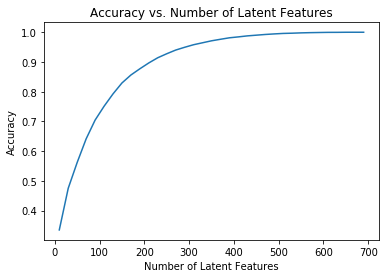

In [63]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    

plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` 通过上述单元格，我们无法判断要使用多少个潜在特征，因为能够更好地预测矩阵的 1 和 0 值，并不表明我们就能做出很好的推荐。我们可以将数据集划分为训练集和测试集，如以下单元格所示。  

根据第三个问题的代码判断，不同的潜在特征数量对训练集和测试集的准确率有何影响。使用以下划分方法： 

* 我们可以对测试集中的多少个用户做出预测？  
* 由于冷启动问题，我们无法对多少个用户做出预测？
* 我们可以对测试集中的多少篇文章做出预测？  
* 由于冷启动问题，我们无法对多少篇文章做出预测？

In [67]:
# 我们可以对测试集中的多少个用户做出预测？
print(len(set(user_item_test.index) & set(user_item_train.index)))

# 由于冷启动问题，我们无法对多少个用户做出预测？
print(len(set(user_item_test.index) - set(user_item_train.index)))

# 我们可以对测试集中的多少篇文章做出预测？
print(len(set(user_item_test.columns.levels[1]) & set(user_item_train.columns.levels[1])) )

# 由于冷启动问题，我们无法对多少篇文章做出预测？
print(len(set(user_item_test.columns.levels[1]) - set(user_item_train.columns.levels[1])))

20
662
574
0


In [66]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    user_item_train = df_train.groupby(['user_id', 'article_id']).count().unstack()
    user_item_train.fillna(0, inplace=True)
    for _, row in user_item_train.iterrows():
        for i in range(row.shape[0]):
            if row[i] >= 1:
                row[i] = 1
                
    user_item_test = df_test.groupby(['user_id', 'article_id']).count().unstack()
    user_item_test.fillna(0, inplace=True)
    for _, row in user_item_test.iterrows():
        for i in range(row.shape[0]):
            if row[i] >= 1:
                row[i] = 1
                
    test_idx = set(user_item_test.index)
    test_arts = set(user_item_test.columns.levels[1])
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [68]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b,  # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d, # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` 现在对上述 **user_item_train** 数据集进行奇异值分解，并得出 U、S 和 V 转置矩阵。然后判断在使用不同的潜在特征数量时，可以使用此矩阵分解方法对 **user_item_test** 数据集中的多少行做出预测，并根据测试数据的准确率确定应该保留多少个潜在特征。

通过以下单元格了解 SVD 在测试数据上做出推荐预测的效果如何。

In [69]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [70]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [71]:
k = 714
s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
np.allclose(user_item_train, np.around(np.dot(np.dot(u_new, s_new), vt_new)))

True

In [72]:
# get user_id which exist in train set to get user embeddings

pred_user_id = sorted(list(test_idx & set(user_item_train.index)))
pred_idx = [i-1 for i in pred_user_id]
#pred_idx

In [73]:
# find all test set articles index in train set to get artical embeddings

col = list(user_item_train.columns.levels[1]) 
article_idx_ = [col.index(i) for i in test_arts]
#len(article_idx_)

[232.0, 248.0, 252.0, 260.0, 269.0, 269.0, 276.0, 276.0, 278.0, 283.0, 288.0, 294.0, 298.0, 303.0, 305.0, 313.0, 318.0, 318.0, 327.0, 328.0, 335.0, 339.0, 343.0, 346.0, 347.0, 350.0, 352.0, 353.0, 357.0]


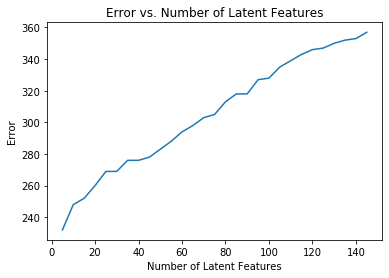

In [74]:
# Use these cells to see how well you can use the training 

num_latent_feats = np.arange(5,150,5)
sum_errs = []

for k in num_latent_feats:
    
    # restructure with k latent features with 20 test users
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[pred_idx, :k], vt_train[:k, article_idx_]
    
    # take dot product
    user_test_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    actual_ = user_item_test.loc[pred_user_id]
    diffs = np.subtract(user_test_est, actual_)

    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))

    sum_errs.append(err)

    
    
print(sum_errs)    
plt.plot(num_latent_feats, np.array(sum_errs));
plt.xlabel('Number of Latent Features');
plt.ylabel('Error');
plt.title('Error vs. Number of Latent Features');
    



`6.` 在以下单元格中解释上个问题的结果。讨论会如何判断上述推荐系统是否比用户目前查找文章的方式更好。 

**可以看出随着number of latent features的增加，预测的错误值也增加（因为矩阵是稀疏矩阵，绝大部分是0），SVD的效果并不好。目前更好的方式是基于用户-用户的协同过滤。可以通过A/B测试来检验实际效果。**



